# Introduction #

This is an interactive demonstration to accompany the manuscript **An application of a machine learning algorithm to determine and describe error patterns within wave model output**. In the manuscript, a bagged regression tree (an ensemble variation of the decision tree applied to continuous data), is applied to correct wave forecasts.


Ellenson, A., Pei, Y., Wilson, G., Özkan-Haller, H. T., & Fern, X. (2020). An application of a machine learning algorithm to determine and describe error patterns within wave model output. Coastal Engineering, 157, 103595.

The following notebook encompasses:


**Application of the Bagged Regression Tree**
1. The dataset
2. Training and testing the bagged regression tree

**Explanation of the Results**
1. Regression tree theory 
2. Regression tree architecture
3. Dataset partitions



# Application of the Bagged Regression Tree #

## Wave Data ##



### Data As Time Series

The dataset is comprised of WW3 output and buoy observations at Stonewall Banks NDBC buoy 46050. 

>The elements of the hourly input feature vectors ($\mathbf{x}_i$) are modelled environmental parameters associated with the forecast for that hour, $i$. These include significant wave height, $Hs$, mean wave direction, $MWD$, mean period $T_m$, wind magnitude, $wndmag$, and wind direction $winddir$. The output target ($y_i$) for this study is the difference between the wave height observations, $H_{s,obs}$, and modelled wave height, $H_{s,WW3}$ for a particular hour, $i$:
    \begin{equation}
    y_i = H_{s,obs} - H_{s,WW3}
    \end{equation}
A negative (positive) target value indicate a wave height overestimation (underestimation).

The data is divided between winter and summer seasons. The training data is from the years 2012-2014, and the testing data is from year 2015. The retrieval of the data from the buoy and the data cleaning has already occurred. In the code below, the data is imported and plotted as a time series. 



The input features are an array of shape (10230, 5)


Text(0.5, 0, 'Time (hrs)')

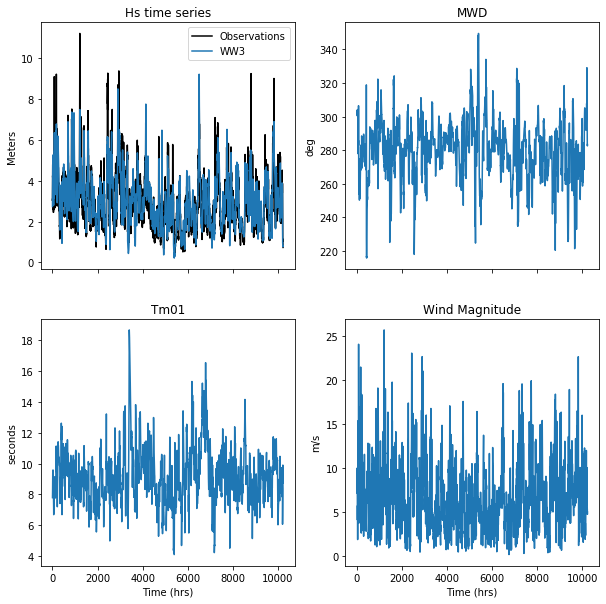

In [1]:
from sklearn import tree
import pickle
import pandas as pd
import matplotlib.pyplot as pl
import matplotlib.cm as cmx
from matplotlib import colors as colors
import scipy.io as sio
import matplotlib as mpl
import numpy as np
import waveDecisionTree
import Error

#Load the data 
waveDTree = waveDecisionTree.waveDecisionTree()
waveDTree.load_data('winter') #this will load the data into the waveDTree object
train_obs = waveDTree.train_obs
train_features = waveDTree.train_features
train_target = waveDTree.train_target


basic_cols=['#ff0000','k','#07076b']
my_cmap=colors.LinearSegmentedColormap.from_list('mycmap', basic_cols)


#Visualize the time series before visualizing the feature space:
fig, ax = pl.subplots(2,2, sharex = True)
fig.set_size_inches(10,10)
ax[0,0].plot(train_obs, label = 'Observations', color = 'k')
ax[0,0].plot(train_features[:,0], label = 'WW3')
ax[0,0].set_title('Hs time series')
ax[0,0].legend()

ax[0,0].set_ylabel('Meters')

ax[0,1].plot(train_features[:,1])
ax[0,1].set_title('MWD')
ax[0,1].set_ylabel('deg')

ax[1,0].plot(train_features[:,2])
ax[1,0].set_ylabel('seconds')
ax[1,0].set_title('Tm01')
ax[1,0].set_xlabel('Time (hrs)')

ax[1,1].plot(train_features[:,3])
ax[1,1].set_ylabel('m/s')
ax[1,1].set_title('Wind Magnitude')
ax[1,1].set_xlabel('Time (hrs)')

### Data As Feature Space 

When the decision tree processes the data, it does not see the data as a continuous time series, but rather as a static feature space where the data are plotted against each other and with respect to the target value.

(0.0, 1.0, 0.0, 1.0)

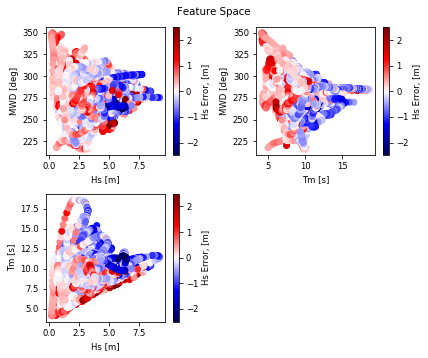

In [2]:
##This section of code plots the training data as a feature space.
mpl.rcParams['font.size'] = 8.5

features = ['Hs [m]','MWD [deg]','Tm [s]']
fig,ax = pl.subplots(2,2, tight_layout = {'rect':[0,0,1,0.95]})
fig.suptitle('Feature Space')
fig.set_size_inches(3,3)
fig.set_size_inches(6,5)
for feat in range(3):
    if feat == 0:
        f1 = 0
        f2 = 1
        a1 = 0
        a2 = 0
    if feat == 1:
        f1 = 2 
        f2 = 1
        a1 = 0
        a2 = 1
    if feat == 2:
        f1 = 0 
        f2 = 2
        a1 = 1
        a2 = 0
    im = ax[a1,a2].scatter(train_features[:,f1], train_features[:,f2],c = train_target, cmap  = 'seismic', vmin = -2.5, vmax = 2.5)
    c = fig.colorbar(im, ax = ax[a1,a2])
    c.set_label('Hs Error, [m]')
    ax[a1,a2].set_xlabel(features[f1])
    ax[a1,a2].set_ylabel(features[f2])
ax[1,1].axis('off')


## Implementing a Bagged Regression Tree in Scikit Learn

In the following sectiong, scikit-learn is used to train and test a decision tree. Once the decision tree is trained and tested, the theory behind the decision making can be understood by inspecting the architecture of the tree. 

Because the data is continuous, a regression tree as opposed to a decision tree (which is used for classification) will be used. Many trees are used as an ensemble, where the examples are pulled with replacement in a bagging technique. Five-fold cross-validation is used to find the optimal bagged tree parameters (including tree size and depth). 

Several key functions are called:

1. RandomForestRegressor : the base learner, or the regression tree itself
2. BaggingRegressor : the ensemble technique
3. GridSearchCV : the cross-validation routine to find the optimal decision tree parameters. 

For the paper, this routine was repeated 30 times, since each bagged regression tree is unique due to the stochastic nature of the routine. In this notebook, the routine is called just two times. 


Training now
Run 0took 2.55seconds featuring Hs_ww3 mwd_ww3 Tm_ww3 wndmag wnddir
Run 1took 2.38seconds featuring Hs_ww3 mwd_ww3 Tm_ww3 wndmag wnddir
Total time is 4.93
RMSE for WW3 is 0.63
RMSE for DT is 0.59


/Users/ashleyellenson/anaconda3/envs/DTree_digital_paper/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/Users/ashleyellenson/anaconda3/envs/DTree_digital_paper/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


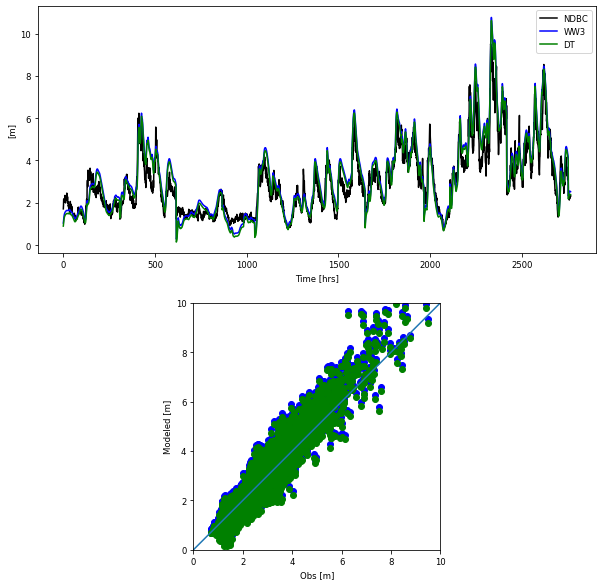

In [3]:
depths = [2,5] #depths to test
treenos = [5,10] #number of trees to test
noruns = 2 #number of times to make a bagged regression forest

obs_hs_test, ww3_hs_test, dt_hs = waveDTree.train_tree(noruns, depths, treenos)

WW3Error = np.zeros((4,1))
DTError = np.zeros((4,1))
WW3Error = Error.getStats(obs_hs_test, ww3_hs_test)
DTError = Error.getStats(obs_hs_test, dt_hs)

#Visualize the results:
fig, ax = pl.subplots(2,1)
fig.set_size_inches(10,10)
ax[0].plot(obs_hs_test, color = 'k', label = 'NDBC')
ax[0].plot(ww3_hs_test, color = 'blue', label = 'WW3')
ax[0].plot(dt_hs, color = 'green', label = 'DT')
ax[0].legend()
ax[0].set_ylabel('[m]')
ax[0].set_xlabel('Time [hrs]')

ax[1].scatter(obs_hs_test, ww3_hs_test, color = 'blue')
ax[1].scatter(obs_hs_test, dt_hs, color = 'green')
ax[1].set_xlabel('Obs [m]')
ax[1].set_ylabel('Modeled [m]')
ax[1].set_xlim((0,10))
ax[1].set_ylim((0,10))
ax[1].plot((0,10),(0,10))
ax[1].set_aspect('equal')

print("RMSE for WW3 is {0:0.2f}".format(WW3Error[0]))
print("RMSE for DT is {0:0.2f}".format(DTError[0]))

 # Explanation of the Results #
 
  This section will show how the bagged regression tree made decisions, and how to apply the bagged regression tree in a descriptive way by using its architecture. 
  
## The Theory behind Decision Making ##
 
 ### Objective Function and Partitioning Data ### 

 
> The objective of the bagged regression tree is to partition the dataset as a feature space. It attempts to find the partitions of the feature space wherein the mean target value of that partition ($\overline{y}(t)$) is most similar to the rest of the target values encompassed within that partition. Specifically, the algorithm seeks the partitions, t, in the entire dataset, T, that minimize the sum of variances in $y_i$ across all the partitions: 
\begin{equation}
\frac{1}{N}\sum_{t\in{T}}\sum_{\mathbf{x}_i\in{t}}{(y_i - \overline{y}(t))^{2}}
\end{equation}
 These partitions are constructed by splitting the target values ${(y_i)}$ with respect to values of the input features ${(\mathbf{x}_i)}$. During the training phase, the regression tree establishes partitions.  See the figure below for an example of how the data is successively split on threshold values of input features, establishing a tree structure. During the testing phase, the regression tree classifies an instance into a partition based on the values of the associated input features (${\mathbf{x}_i}$). The mean target value associated with that partition is then made the prediction for that instance. See the code below for a demonstration of how to plot the final partitions, $\mathbf{t}$, made relative to the entire dataset $T$.

In the following code, the four most populated partitions established by one regression tree in the entire forest is plotted. 
  

## Bagged Regression Tree Structure ##

An example tree is depicted below. Splits are made at nodes, and final partitions are leaves and those are the values that are assigned to the test instance. 

>Representative tree structure of the splits made between the input features during training on the training data set. This decision tree has a depth of 5, meaning that five decisions are made to split the target values into 62 final partitions (not all pictured). The input features (mean wave period, $Tm01$, mean wave direction, $MWD$ and significant wave height, $Hs$) are indicated within each final tree node with a threshold value. Branches to the left (right) represent the division of data points less than (greater than) the threshold value. In the final partitions, MSE is the mean squared error between the member target values within the partition and the mean target value associated with that partition. The MSE is the value which the decision tree seeks to minimize overall the partitions in determining how to split the data space. $\overline{y}(t)$ is the mean target value associated with that partition.  During testing, $\overline{y}(t)$ is made the prediction for the instances which fall into that final partition. Instances fall into the partition because the value of the input features, $\mathbf{x_i}$, correspond with the thresholds determined during training.

<img src = 'DecisionTree_Example.png'>

When the decision tree splits more on one feature than another, this indicates that the feature is better correlated with the target than the other input features. In this case, the target is the error between the wave data and the buoys.  

     Hs_ww3   mwd_ww3    Tm_ww3    wndmag    wnddir
0  0.191467  0.050797  0.418062  0.307270  0.032404
1  0.182433  0.058075  0.429022  0.295134  0.035336


Text(0.5, 1.0, 'Feature Importances')

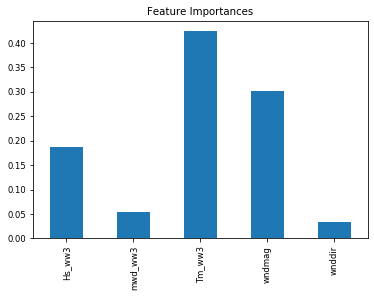

In [4]:
#The feature importance matrix columnns are the input features, and the rows indicate the run number. 
# The numbers sum to 1 and show the relative importance of each feature. 
print(waveDTree.feature_importance_matrix)

fig, ax = pl.subplots(1,1)
waveDTree.feature_importance_matrix.mean().plot(kind = 'bar')
ax.set_title('Feature Importances')

### Bagged Regression Tree Parameters ###

>The number of splits made on a learning data set is referred to as the depth of a tree, and the number of trees used to make the final prediction in the bagged regression tree is the size. The size and depth of each bagged regression tree is determined during the training phase through cross validation, as described by \cite{breiman1992submodel}, and in the following section. Also, a tree might split on one feature more often than another, indicating that the feature is important in its decision making rules. 

   depth  number
0    5.0    10.0
1    5.0     5.0
The best mean DT depth is 5.0
The best mean number of DT is 7.5


Text(0.5, 1.0, 'Optimal Bagged Regression Tree Parameters')

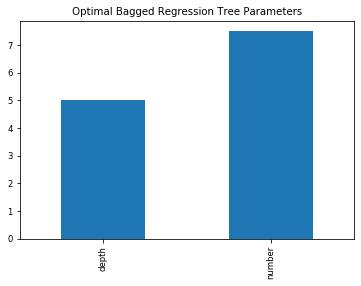

In [5]:
#For each run, the best depth/number of tree combination was saved in the forest parameter matrix. 

print(waveDTree.forest_parameter_matrix)

print("The best mean DT depth is " + str(waveDTree.forest_parameter_matrix['depth'].mean()))
print("The best mean number of DT is " + str(waveDTree.forest_parameter_matrix['number'].mean()))

pl.figure()
waveDTree.forest_parameter_matrix.mean().plot(kind= 'bar')
pl.title('Optimal Bagged Regression Tree Parameters')

Filtered features


(0.0, 1.0, 0.0, 1.0)

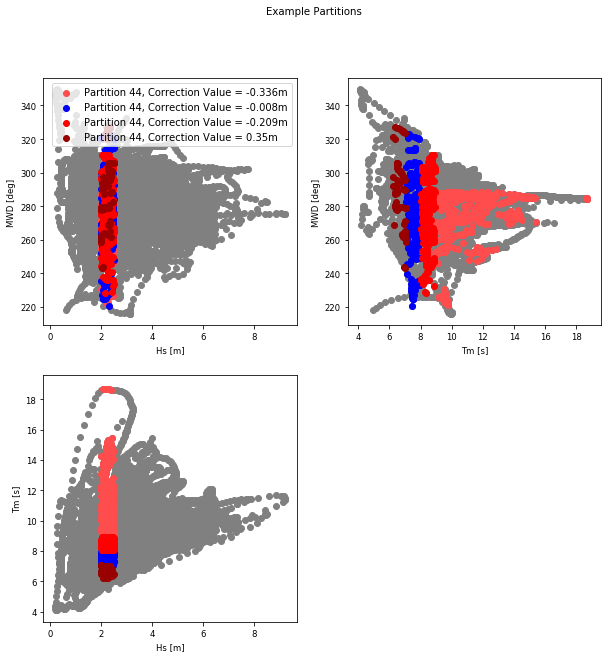

In [6]:
DT_pickle = open('./ExampleDT.pickle','rb')
bestDT = pickle.load(DT_pickle)
DT_pickle.close()

#alternatively can have it guess on test features, in which case the input data and target would be different
inputdata = train_features 
target = waveDTree.train_target

numleaves = 4
treeno = 0
trainfeaturenames = ['Hs', 'MWD', 'Tm', 'wndmag', 'wnddir']
exploreTree = waveDecisionTree.exploreTree(bestDT, inputdata, target, treeno, trainfeaturenames)

# Find the final leaf numbers or partition IDs for the training data. 
#Can choose to use train features or test features:

colors = ['#ff4c4c','#0000ff','#ff0000','#990000']

#If you're interested in certain values of the input features, you can filter the fetaures so only those are evaluated.
feature = 'Hs'
feature_min = 2
feature_max = 2.5

evaluate_features = exploreTree.filter_feature_vals(feature, feature_min, feature_max)


#Target values applied to each partition
leaf_ids, topleaf_ids, correction_vals = exploreTree.top_populated_leaves(numleaves, filter_features = True) #Number of leaves

fig,ax = pl.subplots(2,2)
fig.suptitle('Example Partitions')
fig.set_size_inches(10,10)
for feat in range(3):
    if feat == 0:
        f1 = 0
        f2 = 1
        a1 = 0
        a2 = 0
    if feat == 1:
        f1 = 2 
        f2 = 1
        a1 = 0
        a2 = 1
    if feat == 2:
        f1 = 0 
        f2 = 2
        a1 = 1
        a2 = 0
    ax[a1,a2].scatter(inputdata[:,f1], inputdata[:,f2],color = 'grey')
    ax[a1,a2].set_xlabel(features[f1])
    ax[a1,a2].set_ylabel(features[f2])


    for ii in range(4):
        #Find the indices of the leaf for each partition. 
        leafidx = np.where(leaf_ids == topleaf_ids[ii])[0]
        ax[a1,a2].scatter(evaluate_features[leafidx,f1], evaluate_features[leafidx,f2],color = colors[ii], label = 'Partition ' + str(leaf_ids[ii]) + ", Correction Value = " + str(np.round(correction_vals[ii],3)) + 'm')
        if feat == 0:
            ax[a1,a2].legend(fontsize  = 10)

ax[1,1].axis('off')

### Plot a Partition

We'll choose the most populated partition to explore. This is the region of the model which the bagged regression tree has found to have most repeated model error: 

Text(0.5, 0.98, 'Leaf Correction Value of -0.34 \n WW3 RMSE = 0.65 \n DT RMSE = 0.60')

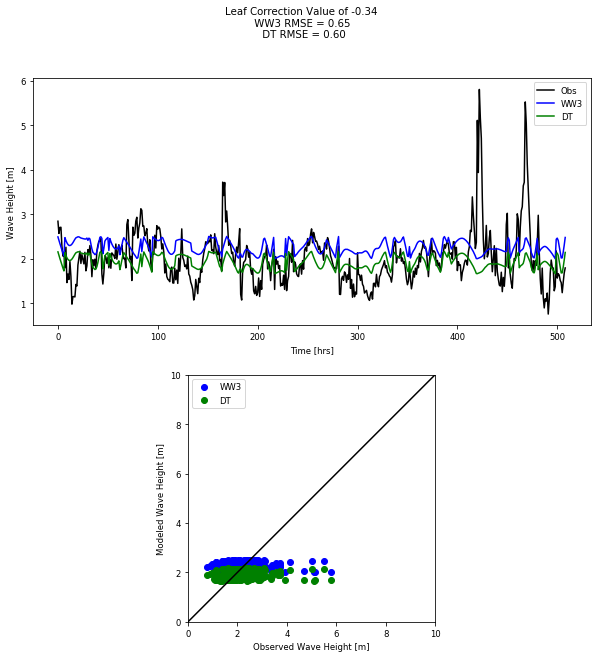

In [7]:
#Pull the top leaf IDs and find those members, then recover Hs and plot


topleafno = topleaf_ids[0] #This is the leaf number you want to explore, 0 is the most populated leaf number
correction = correction_vals[0]
ww3_hs, obs_hs, dt_hs = exploreTree.return_hs(topleafno)

WW3Error = np.zeros((4,1))
DTError = np.zeros((4,1))
WW3Error = Error.getStats(obs_hs, ww3_hs)
DTError = Error.getStats(obs_hs, dt_hs)


fig, ax = pl.subplots(2,1)
fig.set_size_inches((10,10))
ax[0].plot(obs_hs, color = 'k',label = 'Obs')
ax[0].plot(ww3_hs, color = 'blue', label = 'WW3')
ax[0].plot(dt_hs, color = 'green', label = 'DT')
ax[0].set_xlabel('Time [hrs]')
ax[0].set_ylabel('Wave Height [m]')
ax[0].legend()

ax[1].scatter(obs_hs, ww3_hs, color = 'blue', label = 'WW3')
ax[1].scatter(obs_hs,dt_hs, color = 'green', label = 'DT')
ax[1].set_xlim((0,10))
ax[1].set_ylim((0,10))
ax[1].plot((0,10),(0,10), color = 'k')
ax[1].legend()
ax[1].set_xlabel('Observed Wave Height [m]')
ax[1].set_ylabel('Modeled Wave Height [m]')
ax[1].set_aspect('equal')
fig.suptitle('Leaf Correction Value of {0:2.2f} \n WW3 RMSE = {1:2.2f} \n DT RMSE = {2:2.2f}'.format(correction,WW3Error[0], DTError[0]))



### Model Phase Space ###

To find the model phase space where this partition occurs, we trace the decisions made to partition out these examples. 

In [8]:
#Note that the following code is from scikit learn documentation
#Which region of model phase space are these examples from? 
exploreTree.print_rules(topleafno)

Input Feature Phase Space: 
Tm <= 8.939281463623047)
wndmag <= 14.364999771118164)
Tm > 7.075214624404907)
Hs <= 5.490522861480713)
Tm <= 8.032726764678955)
wndmag > -2.0)
